# Importing required libraries

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

# Setting rows and columns

In [104]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Load Data

In [105]:

bike_df = pd.read_csv('day.csv')
print("--- Head of Data ---")
print(bike_df.head())
print("\n--- Data Info ---")
bike_df.info()
print("\n--- Null Values Check ---")
print(bike_df.isnull().sum())

--- Head of Data ---
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  

--- 

# Drop unused columns

In [106]:

bike_df = bike_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)
print("\nColumns remaining:", bike_df.columns.tolist())


Columns remaining: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


# Map categorical codes to labels

In [107]:

season_map = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
weathersit_map = {1: 'Clear', 2: 'Mist_Cloudy', 3: 'Light_Rain_Snow', 4: 'Heavy_Rain_Snow'}
month_map = {i: f'Month_{i}' for i in range(1, 13)}
weekday_map = {0: 'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}

In [108]:
bike_df['season'] = bike_df['season'].map(season_map)
bike_df['weathersit'] = bike_df['weathersit'].map(weathersit_map)
bike_df['mnth'] = bike_df['mnth'].map(month_map)
bike_df['weekday'] = bike_df['weekday'].map(weekday_map)

In [109]:
bike_df['weathersit'] = bike_df['weathersit'].replace('Heavy_Rain_Snow', 'Light_Rain_Snow')

In [110]:
categorical_cols = ['season', 'mnth', 'weekday', 'weathersit']
dummies = pd.get_dummies(bike_df[categorical_cols], drop_first=True)
bike_df = pd.concat([bike_df, dummies], axis=1).drop(categorical_cols, axis=1)

In [111]:
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']
scaler = MinMaxScaler()
print("Numerical columns set; scaler will be fitted on training data after train/test split.")

Numerical columns set; scaler will be fitted on training data after train/test split.


# Train/test split and scaling

In [112]:

y = bike_df['cnt']
X = bike_df.drop('cnt', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


X_train shape: (511, 29), X_test shape: (219, 29)


In [113]:
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]  = scaler.transform(X_test[numerical_cols])

# Ensure numeric types

In [114]:

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test  = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test  = pd.to_numeric(y_test, errors='coerce')

In [115]:
train_mask = X_train.notna().all(axis=1) & y_train.notna()
X_train = X_train.loc[train_mask]
y_train = y_train.loc[train_mask]

In [116]:
test_mask = X_test.notna().all(axis=1) & y_test.notna()
X_test = X_test.loc[test_mask]
y_test = y_test.loc[test_mask]

In [117]:
X_train = X_train.astype(float)
X_test  = X_test.astype(float)
y_train = y_train.astype(float)
y_test  = y_test.astype(float)

# VIF helper

In [118]:

def calculate_vif(X):
    X = X.select_dtypes(include=[np.number])
    vif_data = pd.DataFrame({'Feature': X.columns})
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# Initial model and simple elimination

In [119]:

X_train_sm = sm.add_constant(X_train)
lr1 = sm.OLS(y_train, X_train_sm).fit()

In [120]:
X_train_temp = X_train.drop('temp', axis=1)
X_train_sm2 = sm.add_constant(X_train_temp)
lr2 = sm.OLS(y_train, X_train_sm2).fit()

In [121]:
def safe_drop(df, col):
    return df.drop(col, axis=1) if col in df.columns else df

In [122]:
X_train_3 = safe_drop(X_train_temp, 'mnth_Month_9')
X_train_4 = safe_drop(X_train_3, 'weekday_Saturday')
X_train_5 = safe_drop(X_train_4, 'weekday_Sunday')
X_train_6 = safe_drop(X_train_5, 'mnth_Month_1')
X_train_7 = safe_drop(X_train_6, 'mnth_Month_12')

In [123]:
X_train_sm7 = sm.add_constant(X_train_7)
lr7 = sm.OLS(y_train, X_train_sm7).fit()

FINAL MODEL SUMMARY

In [124]:
print("\n--- FINAL MODEL SUMMARY (lr7) ---")
print(lr7.summary())
print("\n--- VIF for FINAL Model ---")
print(calculate_vif(X_train_7))


--- FINAL MODEL SUMMARY (lr7) ---
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     104.9
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          5.51e-175
Time:                        16:34:04   Log-Likelihood:                -4131.3
No. Observations:                 511   AIC:                             8313.
Df Residuals:                     486   BIC:                             8419.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [125]:
final_features = X_train_7.columns.tolist()

# Predictions and evaluation

In [126]:

X_test_final = sm.add_constant(X_test[final_features])
y_pred = lr7.predict(X_test_final)
r2_test_score = r2_score(y_test, y_pred)
print(f"\nFINAL R-squared on Test Set: {r2_test_score:.4f}")


FINAL R-squared on Test Set: 0.8302


# Residual diagnostics

In [127]:

residuals = y_test - y_pred

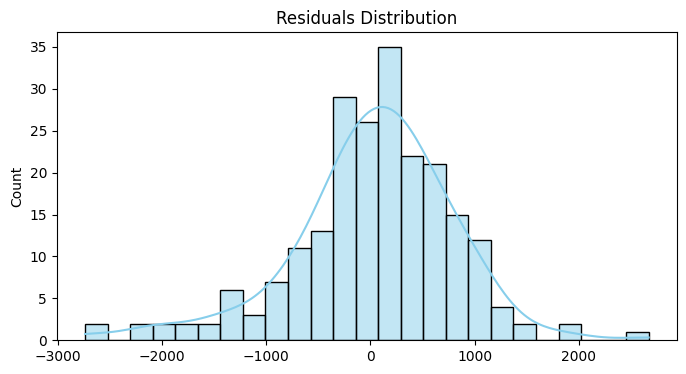

In [128]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=25, kde=True, color='skyblue')
plt.title('Residuals Distribution')
plt.show()

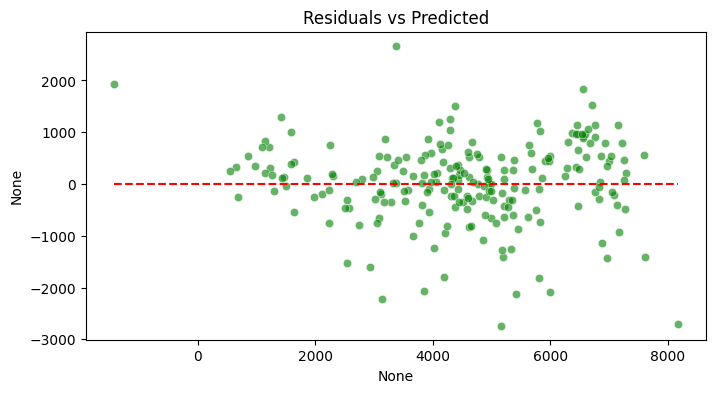

In [129]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.6)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.title('Residuals vs Predicted')
plt.show()

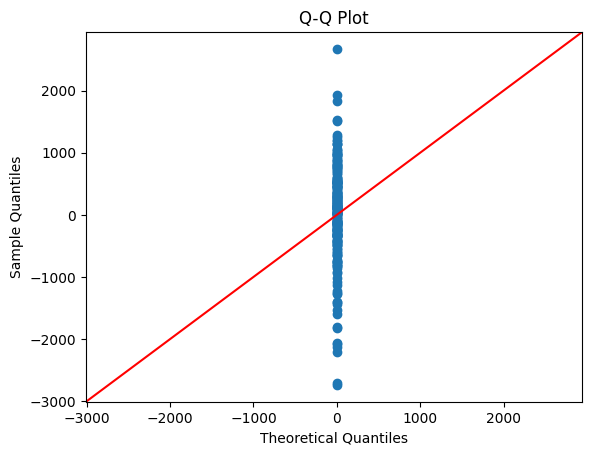

In [130]:
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot')
plt.show()

# Final takeaways and stats

In [131]:

final_coeffs = lr7.params.sort_values(ascending=False)
print("\nTop Predictors:")
print(final_coeffs.head(5))
print(f"\nTest R-squared: {r2_test_score:.4f}")


Top Predictors:
atemp            4566.494322
const            3083.896472
yr               2019.138178
season_winter     286.724698
workingday        251.813659
dtype: float64

Test R-squared: 0.8302
